<a href="https://colab.research.google.com/github/beebatter/Text-Mining-Relation-Extraction/blob/developing/Bert_Method_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ✅ **第一部分: 安装依赖**
!pip install transformers datasets torch scikit-learn matplotlib tqdm nltk
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# ✅ **第二部分: 导入库**
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# ✅ **第三部分: 确保 GPU 可用**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前设备: {device}")
!nvidia-smi

当前设备: cuda
Wed Feb 26 15:46:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------------------------------

In [12]:
# ✅ **第四部分: 加载数据集**
os.makedirs("data", exist_ok=True)
dataset = load_dataset("sem_eval_2010_task_8", download_mode="force_redownload")
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

train-00000-of-00001.parquet:   0%|          | 0.00/673k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/231k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2717 [00:00<?, ? examples/s]

In [13]:
# ✅ **第五部分: 数据预处理**
def extract_entities(sentence):
    """ 从句子中提取 <e1> 和 <e2> 之间的实体 """
    entity1 = re.search(r"<e1>(.*?)</e1>", sentence)
    entity2 = re.search(r"<e2>(.*?)</e2>", sentence)
    entity1 = entity1.group(1) if entity1 else ""
    entity2 = entity2.group(1) if entity2 else ""
    return entity1, entity2

def get_wordnet_definition(entity):
    """ 从 WordNet 获取实体的定义 """
    synsets = wordnet.synsets(entity)
    return synsets[0].definition() if synsets else ""

def enhance_sentence_with_knowledge(sentence):
    """ 用实体知识增强句子（仅使用 WordNet） """
    entity1, entity2 = extract_entities(sentence)
    entity1_info = get_wordnet_definition(entity1)
    entity2_info = get_wordnet_definition(entity2)
    enhanced_sentence = f"{sentence} [SEP] {entity1}: {entity1_info} [SEP] {entity2}: {entity2_info}"
    return enhanced_sentence

df_train["enhanced_sentence"] = df_train["sentence"].apply(enhance_sentence_with_knowledge)
df_test["enhanced_sentence"] = df_test["sentence"].apply(enhance_sentence_with_knowledge)

# 生成 关系标签到 ID 的映射
unique_relations = sorted(df_train["relation"].unique())
label2id = {label: idx for idx, label in enumerate(unique_relations)}
id2label = {idx: label for label, idx in label2id.items()}

df_train["label_id"] = df_train["relation"].map(label2id)
df_test["label_id"] = df_test["relation"].map(label2id)


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
! pip install wikipedia2vec

# 现在本地就有了 enwiki_20180420_100d.pkl

from wikipedia2vec import Wikipedia2Vec

# 如果在同一目录下，就可以直接加载
model_path = "/content/drive/MyDrive/model/enwiki_20180420_100d.pkl"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"未找到 {model_path}，请确认下载/解压是否成功。")

# 加载 Wikipedia2Vec 模型
wiki2vec = Wikipedia2Vec.load(model_path)
print("Wikipedia2Vec 模型加载完成！")

def get_wiki2vec_embedding(entity_name):
    """
    只获取 Wikipedia2Vec 的实体(或词)向量，不做 most_similar，
    若无匹配则返回 None
    """
    item = wiki2vec.get_entity(entity_name)
    if item is not None:
        return wiki2vec.get_entity_vector(item.title)
    # 尝试当作词
    item = wiki2vec.get_word(entity_name)
    if item is not None:
        return wiki2vec.get_word_vector(item.text)
    return None


def get_wiki_embeddings_for_row(row):
    """
    对应 dataframe 的一行，
    提取 sentence 中 <e1>, <e2> 的向量
    """
    e1, e2 = extract_entities(row["sentence"])
    emb1 = get_wiki2vec_embedding(e1)
    emb2 = get_wiki2vec_embedding(e2)

    # 如果找不到实体，就用零向量或 None
    if emb1 is None:
        emb1 = np.zeros(100, dtype=np.float32)  # 维度跟 wiki2vec 模型对应
    if emb2 is None:
        emb2 = np.zeros(100, dtype=np.float32)
    return emb1, emb2

# 对 train, test 做向量提取
df_train[["e1_vec", "e2_vec"]] = df_train.apply(lambda r: pd.Series(get_wiki_embeddings_for_row(r)), axis=1)
df_test[["e1_vec", "e2_vec"]] = df_test.apply(lambda r: pd.Series(get_wiki_embeddings_for_row(r)), axis=1)


/usr/local/lib/python3.11/dist-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[-0.12560804 -0.5235532  -0.13231167 ... -0.48633438  0.45111445
   0.11309847]
 [-0.12473089 -0.6455471   0.13622157 ... -0.6347396   0.5410465
   0.32159257]
 [-0.05129661 -0.4987064  -0.09563554 ... -0.30148467  0.24280211
  -0.08308805]
 ...
 [-1.0583687  -0.83086014 -0.4427682  ... -1.0160557  -0.02469787
   0.99688977]
 [-1.0772408  -0.32139003 -0.79673034 ... -1.3150353  -0.12155519
   0.57841384]
 [-0.86319923 -0.5425662  -0.5506818  ... -1.1069874   0.26995388
   0.43403685]] loaded from the file /content/drive/MyDrive/model/enwiki_20180420_100d.pkl is not byte aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packag

Wikipedia2Vec 模型加载完成！


In [ ]:
# ✅ **第六部分: 加载 BERT 模型**
num_labels = len(label2id)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.to(device)
print(f"✅ 模型已加载到: {next(model.parameters()).device}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ 模型已加载到: cuda:0


In [19]:
# ✅ **第七部分: Tokenization**
def encode_texts(texts, tokenizer, max_length=256):
    return tokenizer(list(texts.values), padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

train_encodings = encode_texts(df_train["enhanced_sentence"], tokenizer)
test_encodings = encode_texts(df_test["enhanced_sentence"], tokenizer)


NameError: name 'tokenizer' is not defined

In [36]:
# ✅ **第八部分: 创建 PyTorch Dataset**
# class RelationDataset(Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return {
#             "input_ids": self.encodings["input_ids"][idx],
#             "attention_mask": self.encodings["attention_mask"][idx],
#             "labels": torch.tensor(self.labels[idx], dtype=torch.long),
#         }

# train_dataset = RelationDataset(train_encodings, df_train["label_id"].tolist())
# test_dataset = RelationDataset(test_encodings, df_test["label_id"].tolist())

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print("✅ Tokenizer 已加载！")

class SemevalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = row["enhanced_sentence"]  # 已带 WordNet 定义
        label = row["label_id"]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        # 注意 e1_vec, e2_vec 是 numpy 向量
        e1_vec = row["e1_vec"]  # shape: (100,)
        e2_vec = row["e2_vec"]  # shape: (100,)

        # 转为 torch.tensor
        e1_vec_tensor = torch.tensor(e1_vec, dtype=torch.float)
        e2_vec_tensor = torch.tensor(e2_vec, dtype=torch.float)


        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long),
            "e1_vec": e1_vec_tensor,
            "e2_vec": e2_vec_tensor,
        }
# train_dataset = SemevalDataset(train_encodings, df_train["label_id"].tolist())
# test_dataset = SemevalDataset(test_encodings, df_test["label_id"].tolist())

✅ Tokenizer 已加载！


In [61]:
# ✅ **第九部分: 加载Bert模型**

# ✅ 设置保存路径
MODEL_SAVE_PATH = "/content/drive/MyDrive/BERTWithWikiVec.pth"
TRAIN_DATA_PATH = "/content/drive/MyDrive/processed_train.pkl"
TEST_DATA_PATH = "/content/drive/MyDrive/processed_test.pkl"

class BERTWithWikiVec(nn.Module):
    def __init__(self, num_labels=9, hidden_size=768, entity_size=100):
        super().__init__()
        from transformers import BertModel
        self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
        self.fc = nn.Linear(hidden_size + 2*entity_size, num_labels)  # 768 + 100 + 100 = 968
        self.wiki_fc = nn.Linear(entity_size, entity_size)  # 100 -> 100（保持100维）

    def forward(self, input_ids, attention_mask, e1_vec, e2_vec, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [batch_size, 768]
        attentions = outputs.attentions  # 提取 Self-Attention

        # **检测哪些样本是类别 18**
        if labels is not None:
            mask_18 = labels == 18
            e1_vec[mask_18] = torch.zeros_like(e1_vec[mask_18])
            e2_vec[mask_18] = torch.zeros_like(e2_vec[mask_18])

        # 维度转换
        e1_vec = self.wiki_fc(e1_vec)  # 100 维
        e2_vec = self.wiki_fc(e2_vec)  # 100 维

        # 拼接
        combined = torch.cat([cls_embedding, e1_vec, e2_vec], dim=1)  # => [batch_size, 968]
        logits = self.fc(combined)

        return logits, attentions  # 额外返回 Attention

        model = BERTWithWikiVec(num_labels=len(unique_relations))
        model.to(device)

In [55]:
# ✅ **第十部分: 训练模型**


model = BERTWithWikiVec(num_labels=len(unique_relations))
model.to(device)

from torch.nn import CrossEntropyLoss
class_counts = df_train["label_id"].value_counts().sort_index()
total_samples = len(df_train)


### 损失函数权重调整

import torch
from torch.nn import CrossEntropyLoss

# 统计每个类别的样本数
class_counts = df_train["label_id"].value_counts().sort_index()
total_samples = len(df_train)

# ✅ 使用平方根反比权重（平滑处理）
weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float))

# ✅ 归一化：确保权重和类别数保持相对均衡
weights = weights / weights.sum() * len(class_counts)

# ✅ **人为调整类别 18 的权重**（如果需要的话）
weights[18] *= 0.8  # 适当增加类别 18 的权重（你可以调整 0.7 或 0.9）

# # ✅ 转换为 PyTorch 张量，并传入 GPU
# class_weights = weights.to(device)

# # ✅ 使用加权损失
# criterion = CrossEntropyLoss(weight=class_weights)

# print("类别权重:", class_weights)

class FocalLoss(nn.CrossEntropyLoss):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = super().forward(input, target)
        p_t = torch.exp(-ce_loss)
        focal_loss = (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()

# 计算类别权重
class_weights = weights.to(device)

# ✅ 替换损失函数
criterion = FocalLoss(weight=class_weights)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print(" Tokenizer 已加载！")

train_dataset = SemevalDataset(df_train, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

for epoch in range(8):
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        e1_vec = batch["e1_vec"].to(device)
        e2_vec = batch["e2_vec"].to(device)

        optimizer.zero_grad()

        # 修改这行：
        logits, _ = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            e1_vec=e1_vec,
            e2_vec=e2_vec
        )


        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} - Loss: {loss.item():.4f}")



 Tokenizer 已加载！
Epoch 0 - Loss: 0.1118
Epoch 1 - Loss: 0.0802
Epoch 2 - Loss: 0.0033
Epoch 3 - Loss: 0.0184
Epoch 4 - Loss: 0.0039
Epoch 5 - Loss: 0.0083
Epoch 6 - Loss: 0.0018
Epoch 7 - Loss: 0.0004


In [52]:
!pip install matplotlib seaborn bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 8.2 MB/s eta 0:00:00


测试集性能:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       134
           1       0.89      0.96      0.93       194
           2       0.87      0.87      0.87       162
           3       0.81      0.81      0.81       150
           4       0.85      0.94      0.89       153
           5       0.83      0.97      0.89        39
           6       0.92      0.91      0.92       291
           7       1.00      0.00      0.00         1
           8       0.91      0.84      0.87       211
           9       0.93      0.87      0.90        47
          10       0.56      0.91      0.69        22
          11       0.76      0.89      0.82       134
          12       0.62      0.81      0.70        32
          13       0.84      0.94      0.89       201
          14       0.83      0.96      0.89       210
          15       0.77      0.96      0.85        51
          16       0.80      0.86      0.83       108
          17       0

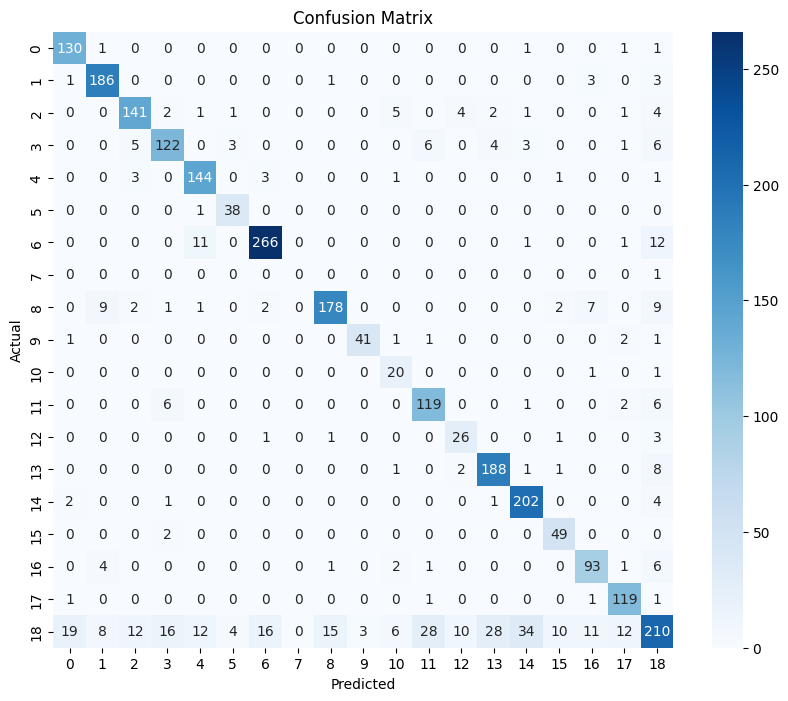

❌ 预测错误的样本（随机抽取 10 条）:
                                               Sentence  True Label  \
229   Gas <e1>drilling</e1> threatens public with un...          18   
1033  Developed in 1979, depressed center <e1>wheels...          18   
66    One simple <e1>method</e1> for clearing small ...          18   
875   In the 2006 Robin Hood series, Robin at one po...          18   
2705  The <e1>sample</e1> was pressed from <e2>powde...          18   
2345  The <e1>act</e1> promotes efficiency through <...          11   
1544  <e1>Concerns</e1> regarding <e2>data protectio...          18   
712   Down one wall was a series of blueprints, to w...          13   
93    The <e1>castle</e1> was inside a <e2>museum</e2>.           2   
101   The monitoring <e1>station</e1> receives the s...           3   

      Predicted Label  
229                11  
1033                0  
66                 11  
875                13  
2705                8  
2345               14  
1544               14  
712 

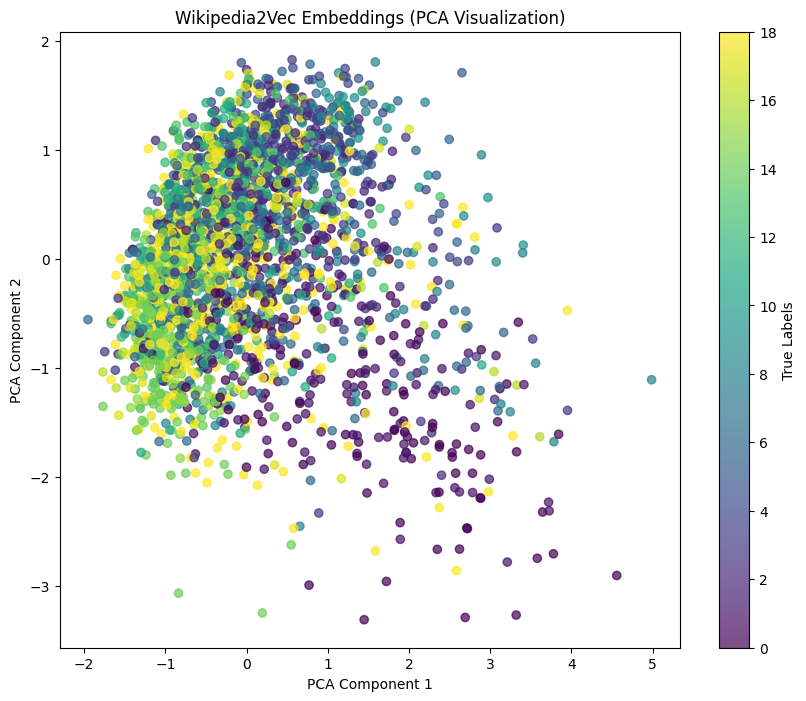

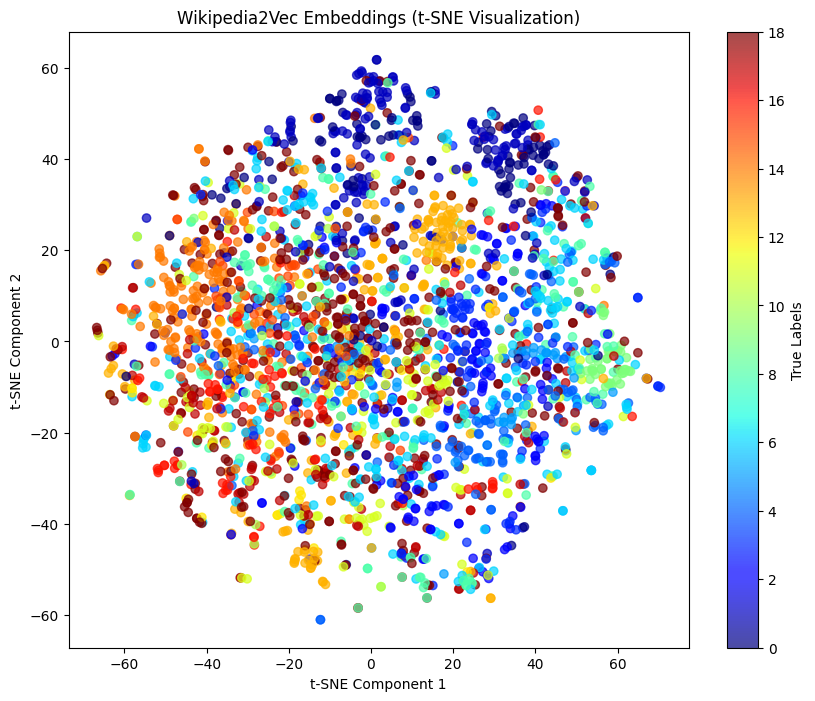

ValueError: The attention tensor does not have the correct number of dimensions. Make sure you set output_attentions=True when initializing your model.

In [62]:
# ✅ **第十一部分: 评估模型**
# model.eval()
# all_preds, all_labels = [], []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         outputs = model(input_ids, attention_mask=attention_mask)
#         predictions = torch.argmax(outputs.logits, dim=1)

#         all_preds.extend(predictions.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# print("真实标签 (all_labels) 示例:", all_labels[:10])
# print("预测标签 (all_preds) 示例:", all_preds[:10])
# print("关系类别 (label2id.keys()):", list(label2id.keys()))

# print("测试集性能:")
# print(classification_report(all_labels, all_preds, target_names=[str(label) for label in label2id.keys()], zero_division=1))

# print("✅ 代码执行完毕，训练和测试都已完成！")

# =======================================
# ✅ 第十一部分: 评估模型
# =======================================
test_dataset = SemevalDataset(df_test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from bertviz import head_view
from transformers import BertTokenizer

# ✅ **1️⃣ 评估模型**
model.eval()
all_preds, all_labels, all_attentions = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        e1_vec = batch["e1_vec"].to(device)
        e2_vec = batch["e2_vec"].to(device)

        outputs, attentions = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            e1_vec=e1_vec,
            e2_vec=e2_vec
        )
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_attentions.append(attentions)  # 只保存最后一层 Attention

print("测试集性能:")
print(classification_report(all_labels, all_preds, target_names=[str(label) for label in label2id.keys()], zero_division=1))

# ✅ **2️⃣ 混淆矩阵**
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ **3️⃣ 错误样本分析**
df_errors = pd.DataFrame({
    "Sentence": df_test["sentence"],
    "True Label": all_labels,
    "Predicted Label": all_preds
})
df_errors = df_errors[df_errors["True Label"] != df_errors["Predicted Label"]]
print("❌ 预测错误的样本（随机抽取 10 条）:")
print(df_errors.sample(10))

# ✅ **4️⃣ Wikipedia2Vec 向量可视化**
e1_vectors = np.vstack(df_test["e1_vec"].values)
e2_vectors = np.vstack(df_test["e2_vec"].values)
entity_vectors = np.hstack([e1_vectors, e2_vectors])

# PCA 降维
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(entity_vectors)
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="True Labels")
plt.title("Wikipedia2Vec Embeddings (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# ✅ **5️⃣ t-SNE 降维**
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
wiki_vec_2d = tsne.fit_transform(entity_vectors)
plt.figure(figsize=(10, 8))
plt.scatter(wiki_vec_2d[:, 0], wiki_vec_2d[:, 1], c=all_labels, cmap='jet', alpha=0.7)
plt.colorbar(label="True Labels")
plt.title("Wikipedia2Vec Embeddings (t-SNE Visualization)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

from bertviz import head_view
from transformers import BertTokenizer

# ✅ **确保加载 `bert_tokenizer`**
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ **选取第 0 层 Attention**
example_attention = all_attentions[0][-1].cpu().numpy()  # ✅ 取最后一层的 Attention

# ✅ **获取输入 Token**
sentence = df_test["sentence"].iloc[0]
inputs = bert_tokenizer(sentence, return_tensors="pt")

# ✅ **可视化 Attention**
head_view(example_attention, inputs["input_ids"], bert_tokenizer)

